# Hands-on 03: Tabular data and NNs: Classifying particle jets

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import numpy as np
import tensorflow as tf

%matplotlib inline
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)


2025-02-13 22:40:31.349413: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 22:40:31.355354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739482831.362964  120929 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739482831.365662  120929 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 22:40:31.373926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Fetch the jet tagging dataset from Open ML

In [2]:
data = fetch_openml("hls4ml_lhc_jets_hlf", parser="auto")
X, y = data["data"], data["target"]

## Let’s print some information about the dataset
Print the feature names and the dataset shape

In [3]:
print(f"Feature names: {data['feature_names']}")
print(f"Target names: {y.dtype.categories.to_list()}")
print(f"Shapes: {X.shape}, {y.shape}")
print(f"Inputs: {X}")
print(f"Targets: {y}")

Feature names: ['zlogz', 'c1_b0_mmdt', 'c1_b1_mmdt', 'c1_b2_mmdt', 'c2_b1_mmdt', 'c2_b2_mmdt', 'd2_b1_mmdt', 'd2_b2_mmdt', 'd2_a1_b1_mmdt', 'd2_a1_b2_mmdt', 'm2_b1_mmdt', 'm2_b2_mmdt', 'n2_b1_mmdt', 'n2_b2_mmdt', 'mass_mmdt', 'multiplicity']
Target names: ['g', 'q', 't', 'w', 'z']
Shapes: (830000, 16), (830000,)
Inputs:            zlogz  c1_b0_mmdt  c1_b1_mmdt  c1_b2_mmdt  c2_b1_mmdt  c2_b2_mmdt  \
0      -2.935125    0.383155    0.005126    0.000084    0.009070    0.000179   
1      -1.927335    0.270699    0.001585    0.000011    0.003232    0.000029   
2      -3.112147    0.458171    0.097914    0.028588    0.124278    0.038487   
3      -2.666515    0.437068    0.049122    0.007978    0.047477    0.004802   
4      -2.484843    0.428981    0.041786    0.006110    0.023066    0.001123   
...          ...         ...         ...         ...         ...         ...   
829995 -3.575320    0.473246    0.040693    0.005605    0.053711    0.004402   
829996 -2.408292    0.429539    0.0400

Many of these variables are energy correlation functions $N,`M,~C,$ and $D$ (1305.0007, 1609.07483). The others are the jet mass (computed with modified mass drop) $m_\text{mMDT}$, $\sum z\log z$
,
where the sum is over the particles in the jet and
is the fraction of jet momentum carried by a given particle, and the overall multiplicity of particles in the jet.

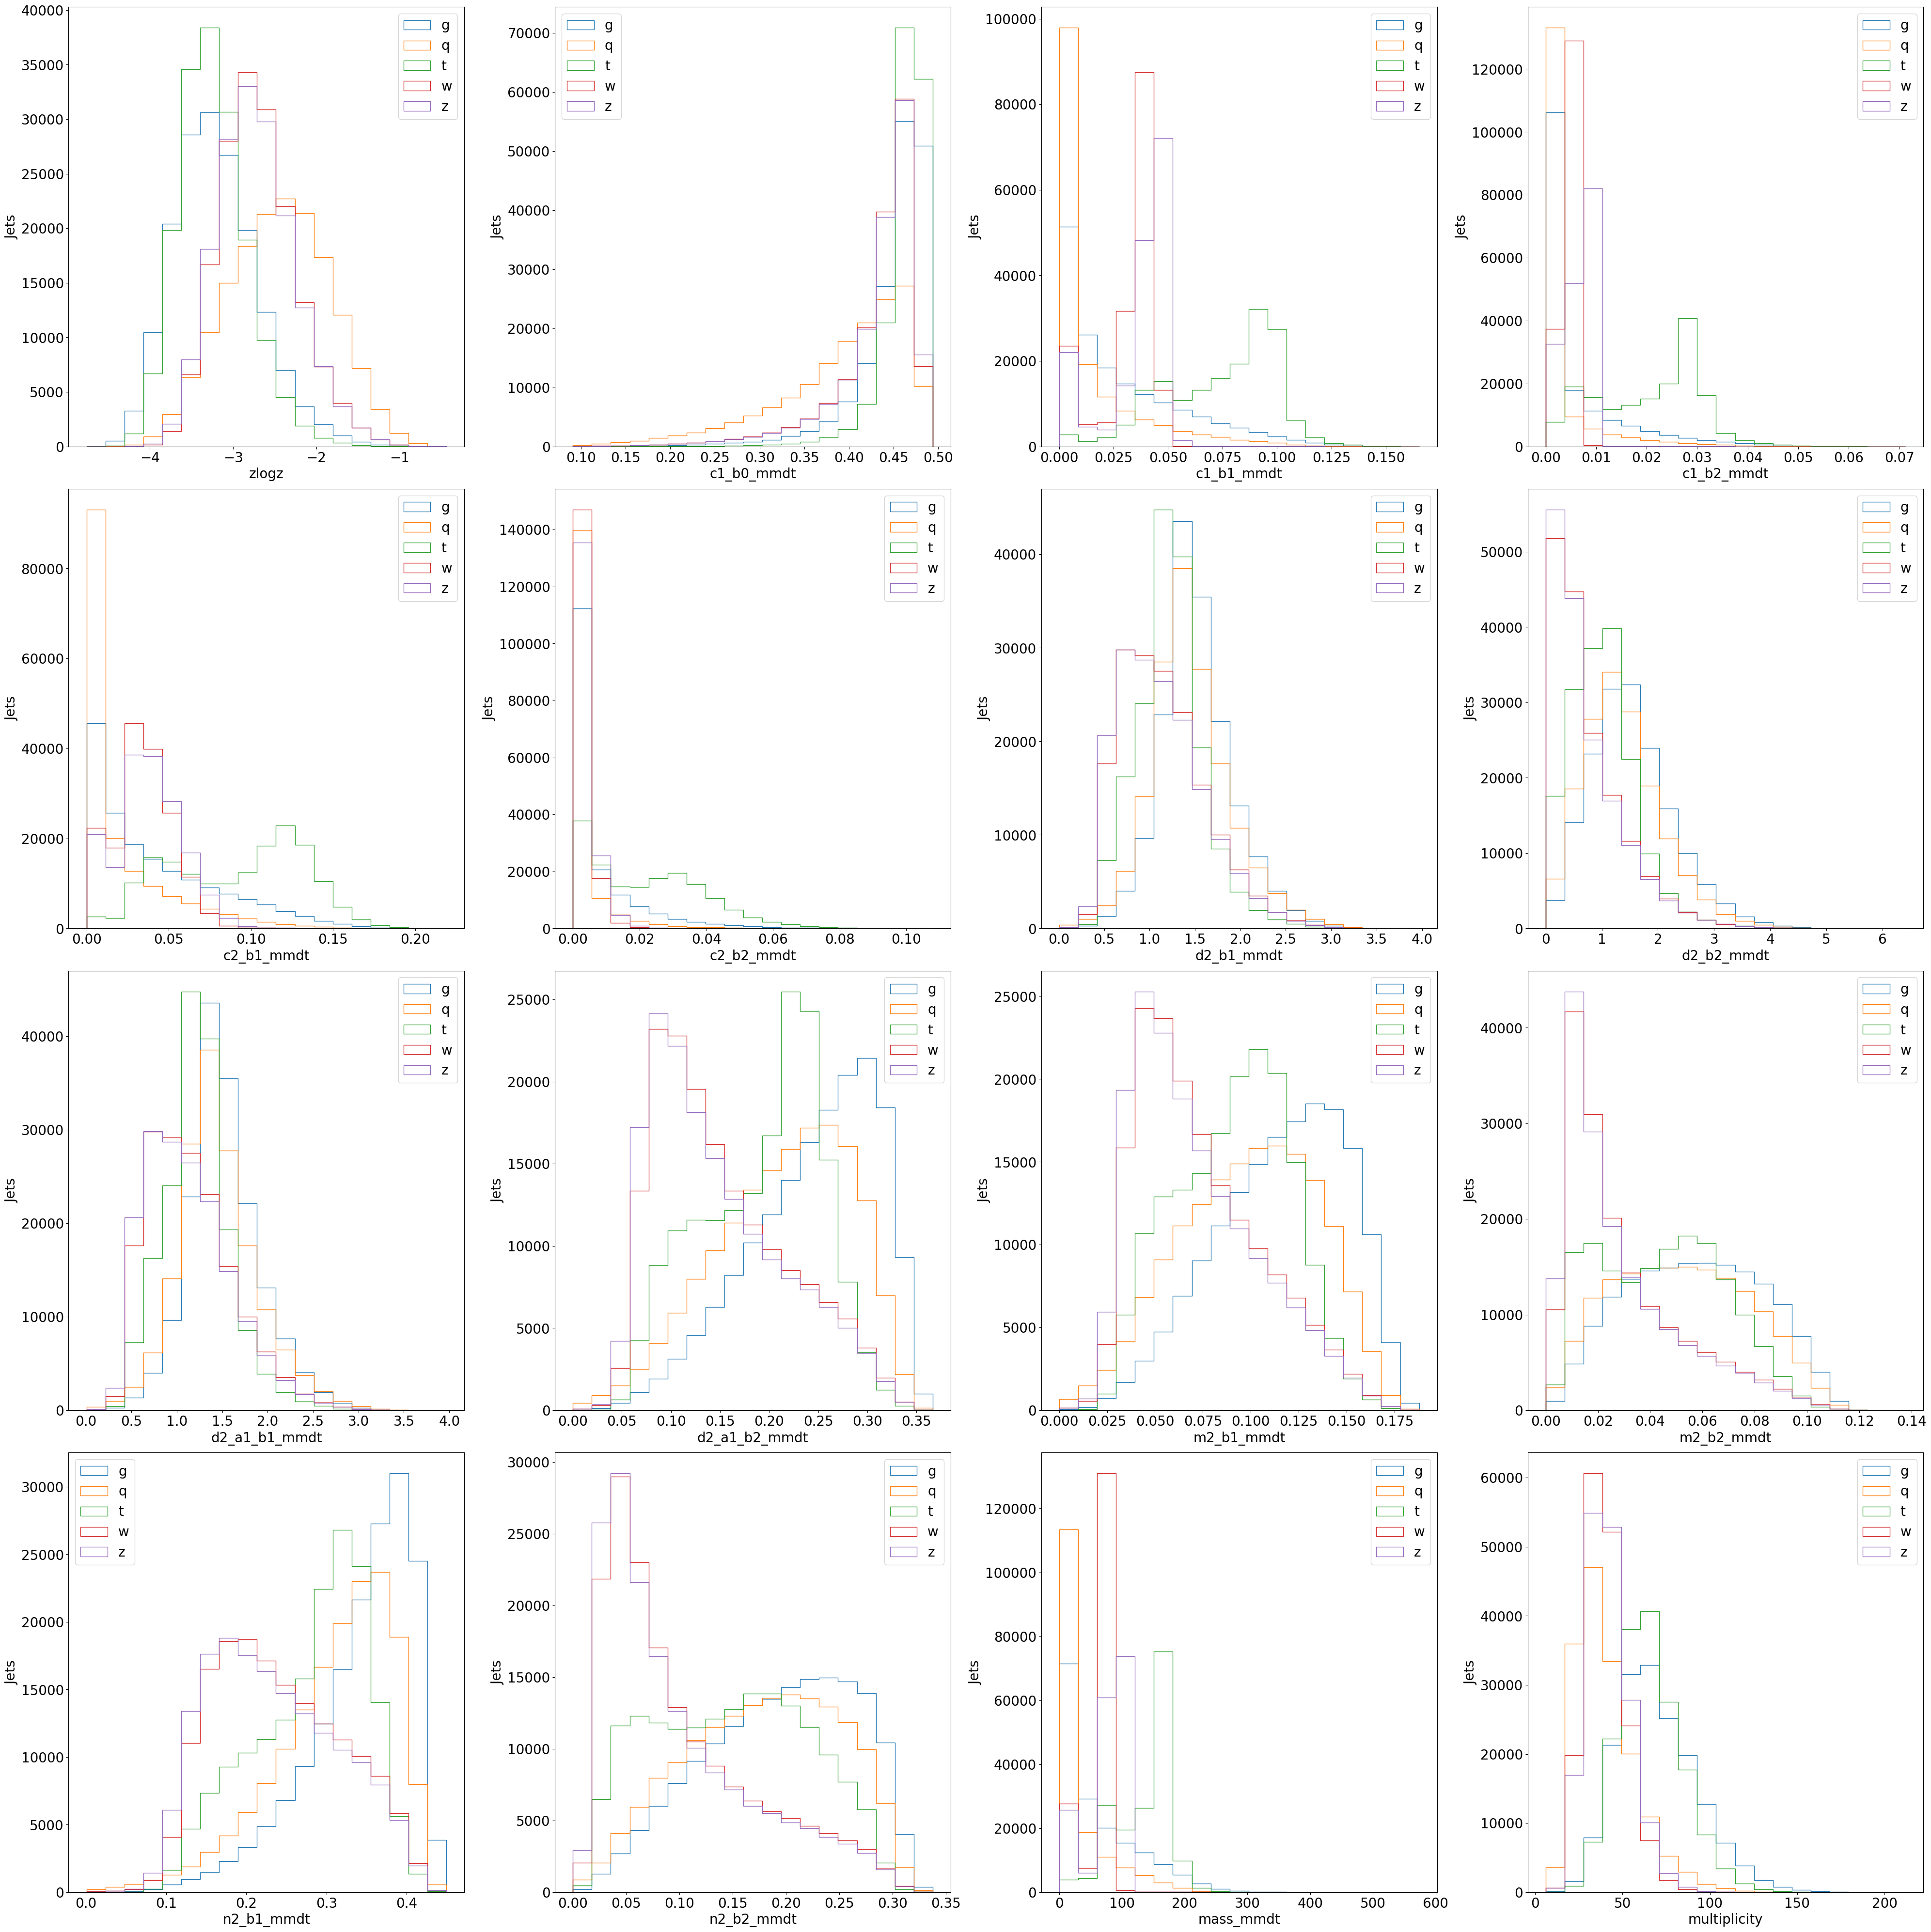

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 4, figsize=(40, 40))

for ix, ax in enumerate(axs.reshape(-1)):
    feat = data["feature_names"][ix]
    bins = np.linspace(np.min(X[:][feat]), np.max(X[:][feat]), 20)
    for c in y.dtype.categories:
        ax.hist(X[y == c][feat], bins=bins, histtype="step", label=c, lw=2)
    ax.set_xlabel(feat, fontsize=20)
    ax.set_ylabel("Jets", fontsize=20)
    ax.tick_params(axis="both", which="major", labelsize=20)
    ax.legend(fontsize=20, loc="best")
plt.tight_layout()
plt.show()

Because the `y` target is an array of strings, e.g. `["g", "w", ...]`, we need to make this a “one-hot” encoding for the training. Then, split the dataset into training and validation sets

In [5]:
le = LabelEncoder()
y_onehot = le.fit_transform(y)
y_onehot = to_categorical(y_onehot, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
print(y[:5])
print(y_onehot[:5])

0    g
1    w
2    t
3    z
4    w
Name: class, dtype: category
Categories (5, object): ['g', 'q', 't', 'w', 'z']
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]]


## Now construct a simple neural network
We’ll use 3 hidden layers with 64, then 32, then 32 neurons. Each layer will use relu activation. Add an output layer with 5 neurons (one for each class), then finish with Softmax activation.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1

In [8]:
model = Sequential(name="sequantial1")
model.add(Dense(64, input_shape=(16,), name="fc1"))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="fc4"))
model.add(Activation(activation="softmax", name="softmax"))
model.summary()

/home/ilija/anaconda3/envs/deep-learn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1739482873.415210  120929 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6206 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequantial1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model
We’ll use SGD optimizer with categorical crossentropy loss. The model isn’t very complex, so this should just take a few minutes even on the CPU

In [9]:
model.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)

I0000 00:00:1739482878.908178  121252 service.cc:148] XLA service 0x7a9c5c003f30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739482878.908207  121252 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-02-13 22:41:18.916930: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739482878.940456  121252 cuda_dnn.cc:529] Loaded cuDNN version 90701
2025-02-13 22:41:19.695688: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_224', 88 bytes spill stores, 88 bytes spill loads

2025-02-13 22:41:19.832883: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220',

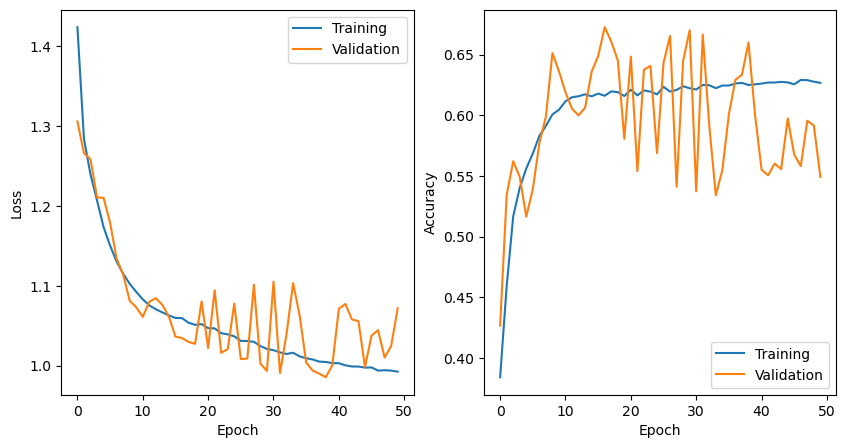

In [10]:
from plotting import plot_model_history

plot_model_history(history)

## Check performance
Check the accuracy and make a ROC curve

In [11]:
from plotting import make_roc, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix

y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

Accuracy: 0.5489819277108434


<Figure size 500x500 with 0 Axes>

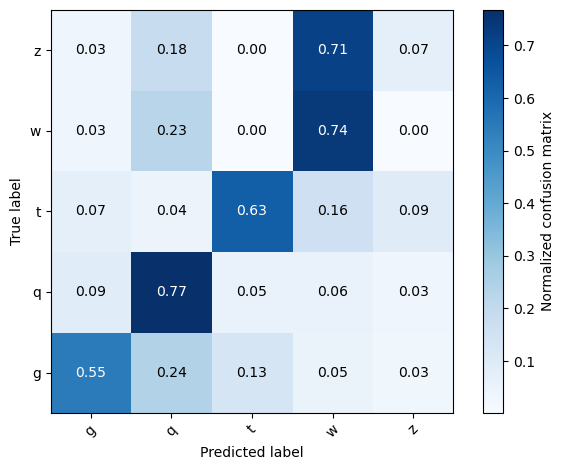

In [12]:
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

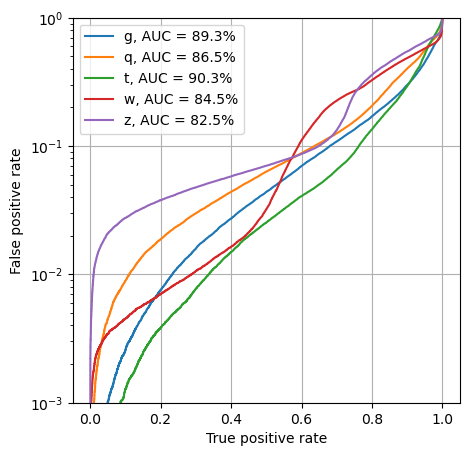

In [13]:
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

# Exercises
## 1.  Apply a standard scaler to the inputs. How does the performance of the model change?


In [14]:
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

### Training the model

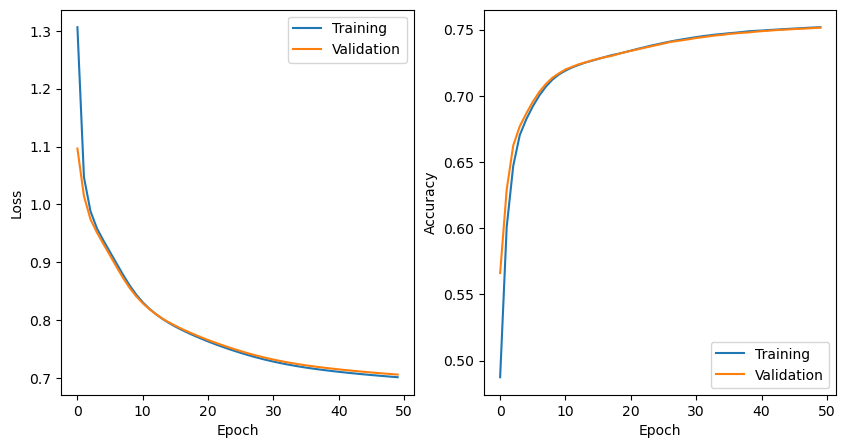

In [15]:
# Training the model
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

### Checking performance

Accuracy: 0.7493132530120482


<Figure size 500x500 with 0 Axes>

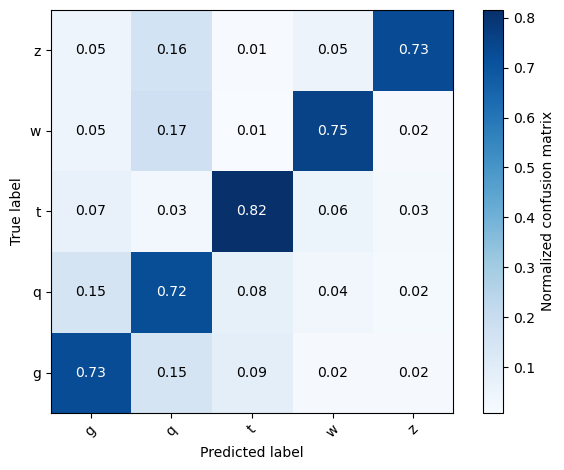

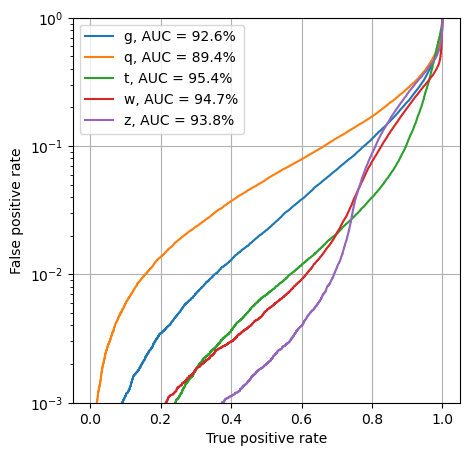

In [16]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

## 2. Apply L1 regularization. How does the performance of the model change? How do the distribution of the weight values change?

### Redifining model

In [17]:

model = Sequential(name="sequantial1")
model.add(Dense(64, input_shape=(16,), name="fc1", kernel_regularizer=l1(0.01)))
model.add(Activation(activation="relu", name="relu1"))
model.add(Dense(32, name="fc2"))
model.add(Activation(activation="relu", name="relu2"))
model.add(Dense(32, name="fc3"))
model.add(Activation(activation="relu", name="relu3"))
model.add(Dense(5, name="fc4"))
model.add(Activation(activation="softmax", name="softmax"))
model.summary()


/home/ilija/anaconda3/envs/deep-learn/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequantial1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                     │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (Activation)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc3 (Dense)                     │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (Activation)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc4 (Dense)                     │ (None, 5)              │           165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Activation)            │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,389 (17.14 KB)

 Trainable params: 4,389 (17.14 KB)

 Non-trainable params: 0 (0.00 B)

## Training the model

QUESTION: Should we still have the standared scaler applied to the inputs?

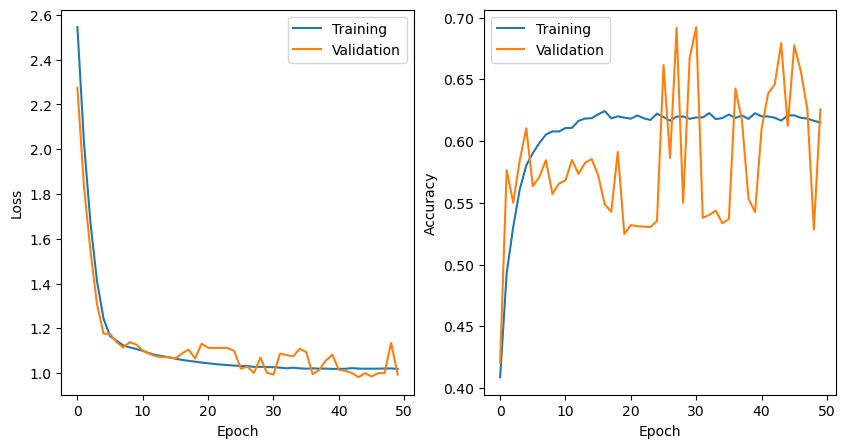

In [19]:
# Training the model


X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

model.compile(optimizer="sgd", loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

### Checking performance

Accuracy: 0.6252710843373493


<Figure size 500x500 with 0 Axes>

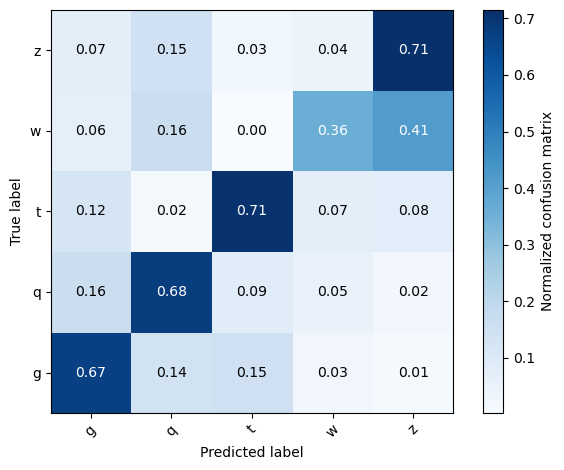

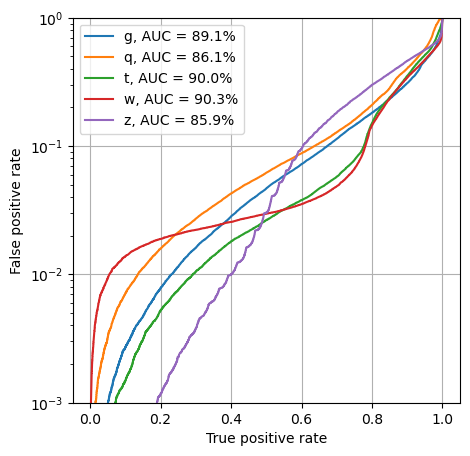

In [20]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

## 3. How do the loss curves change if we use a smaller learning rate (say `1e-5`) or a larger one (say `0.1`)?

### Smaller Learning rate

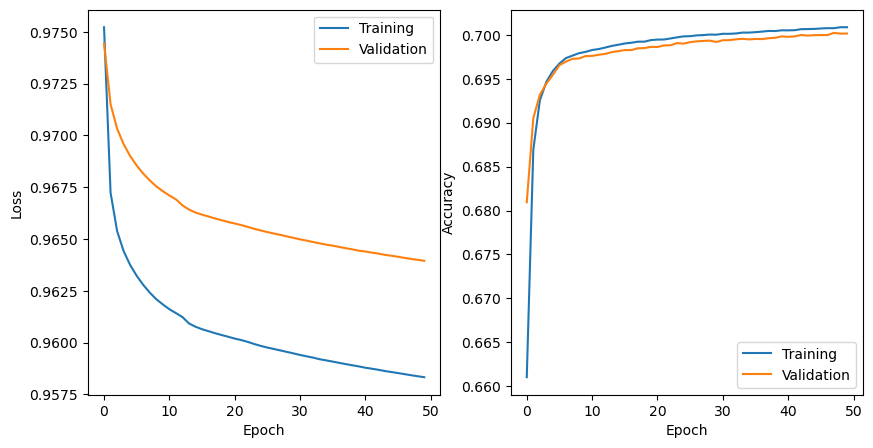

In [ ]:
optimizer_smaller = SGD(learning_rate=1e-5)

model.compile(optimizer=optimizer_smaller, loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)


Accuracy: 0.6999457831325301


<Figure size 500x500 with 0 Axes>

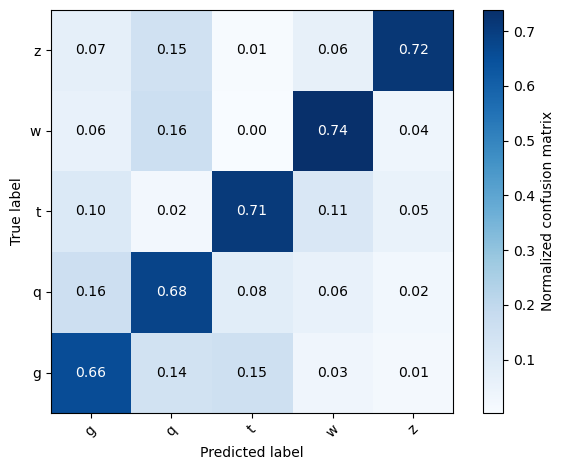

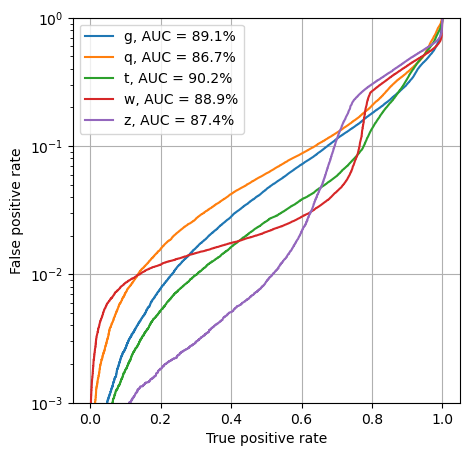

In [28]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

### Larger learning rate

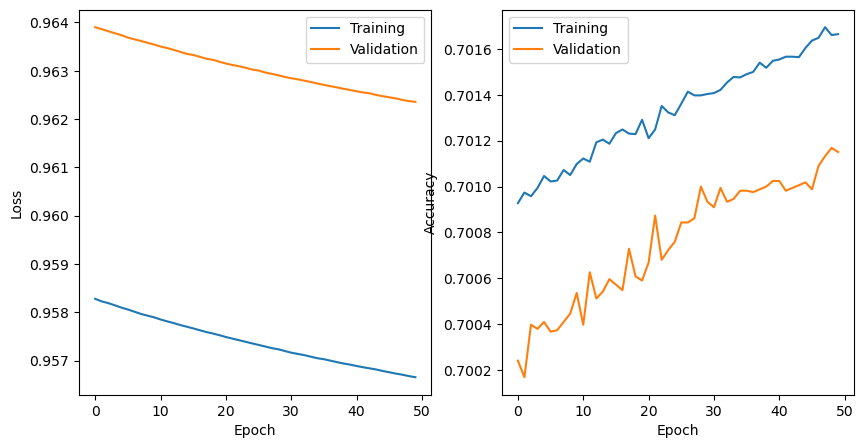

In [29]:
optimizer_larger = SGD(learning_rate=0.1)
model.compile(optimizer=optimizer_smaller, loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

Accuracy: 0.700644578313253


<Figure size 500x500 with 0 Axes>

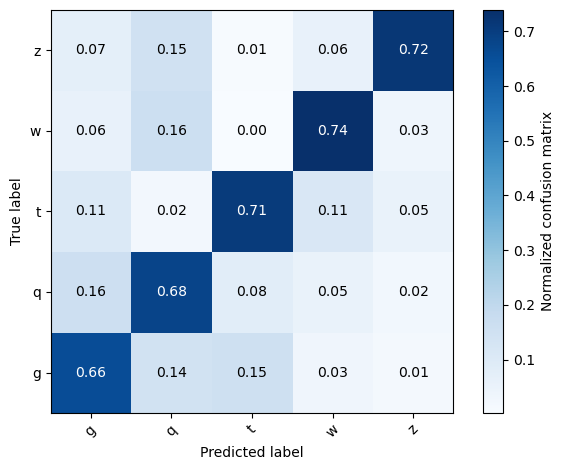

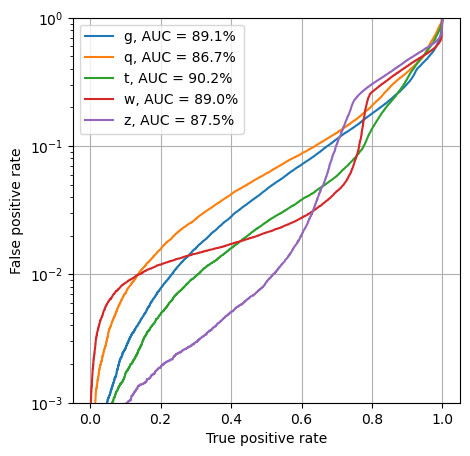

In [30]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)

## 4. How does the loss curve change and the performance of the model change if we use Adam as the optimizer instead of SGD?

2025-02-13 23:01:02.899115: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_392', 88 bytes spill stores, 88 bytes spill loads

2025-02-13 23:01:03.050929: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_390', 136 bytes spill stores, 136 bytes spill loads

2025-02-13 23:01:03.053023: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_388', 172 bytes spill stores, 172 bytes spill loads

2025-02-13 23:01:03.154971: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_392', 2724 bytes spill stores, 2712 bytes spill loads

2025-02-13 23:01:03.229643: I external/local_xla/xla/str

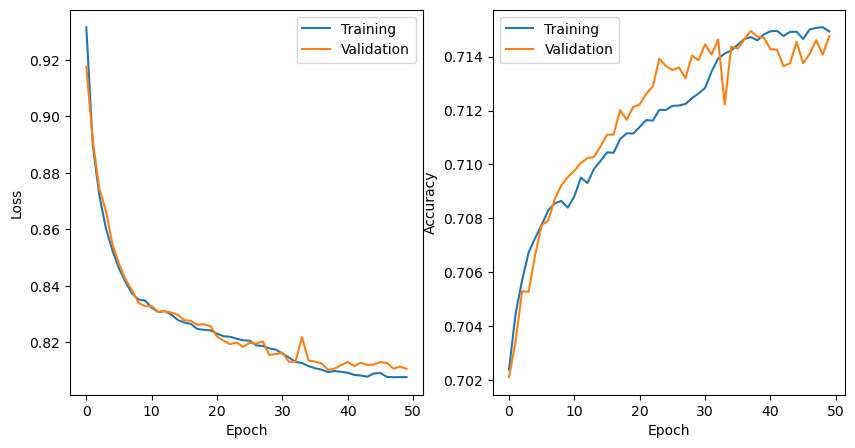

In [31]:
model.compile(optimizer='adam', loss=["categorical_crossentropy"], metrics=["accuracy"])
history = model.fit(X_train_val, y_train_val, batch_size=1024, epochs=50, validation_split=0.25, shuffle=True, verbose=0)
plot_model_history(history)

Accuracy: 0.7134759036144578


<Figure size 500x500 with 0 Axes>

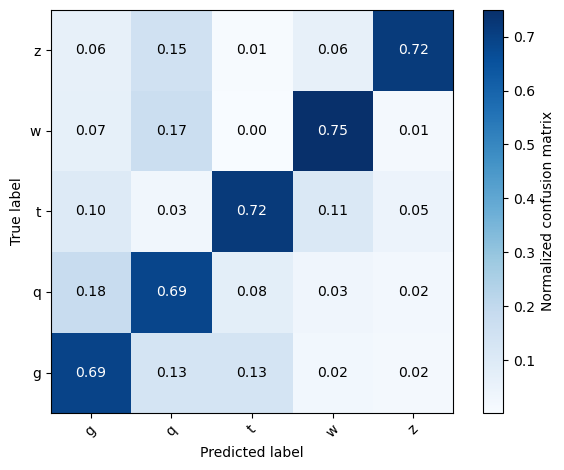

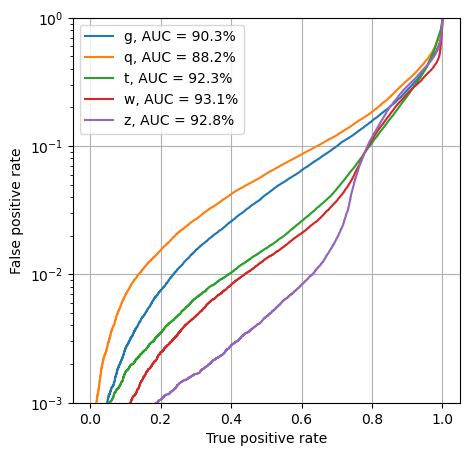

In [32]:
# Accuracy
y_keras = model.predict(X_test, batch_size=1024, verbose=0)
print(f"Accuracy: {accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))}")

#confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(y_test, y_keras, classes=le.classes_, normalize=True)

# ROC curves
plt.figure(figsize=(5, 5))
make_roc(y_test, y_keras, le.classes_)